In [1]:
import torch.nn as nn
import torch
import pdb

import sys, os
import random
import numpy as np
from shutil import copy
import matplotlib.pyplot as plt
from copy import deepcopy

from omegaconf import OmegaConf
import shutil
import pickle
import random
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict

In [2]:
# run_path = '/home/harishbabu/projects/PIPNet/runs/010-CUB-27-imgnet_OOD_cnext26_img=224_nprotos=20'
# run_path = '/home/harishbabu/projects/PIPNet/runs/031-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/032-CUB-18-imgnet_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/035-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = '/home/harishbabu/projects/PIPNet/runs/043-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel'
# run_path = "/home/harishbabu/projects/PIPNet/runs/036-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel_uniformity"
# run_path = "/home/harishbabu/projects/PIPNet/runs/041-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/042-035_clone-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/044-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=20-or-4per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/046-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=10per-desc_orth-on-rel"
# run_path = "/home/harishbabu/projects/PIPNet/runs/047-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc"
# run_path = "/home/harishbabu/projects/PIPNet/runs/048-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=5per-desc_tanh-desc_unit-sphere"
# run_path = "/home/harishbabu/projects/PIPNet/runs/051-CUB-18-imgnet_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/052-CUB-18-imgnet_OOD_cnext26_img=224_nprotos=4per-desc_tanh-desc_unit-sphere_AW=5-TW=2-UW=2-CW=2"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-007-AL=3_UW=3"
# run_path = "/home/harishbabu/projects/PIPNet/runs/pretraining-check-010-no-pretraining"
# run_path = "/home/harishbabu/projects/PIPNet/runs/069-CUB-18_with-equalize-aug_cnext26_img=224_nprotos=4per-desc_unit-sphere_finetune=5_no-meanpool_no-softmax_AW=3-TW=2-UW=3-CW=2_batch=20"
run_path = "/home/harishbabu/projects/PIPNet/runs/082-CUB-18-imgnet_with-equalize-aug_cnext26_img=224_nprotos=4per-leaf-desc_unit-sphere_finetune=5_no-meanpool_with-softmax_no-addon-bias_AW=3-TW=2-MMW=2-UW=3-CW=2_mm-loss_batch=48"

try:
    sys.path.remove('/home/harishbabu/projects/PIPNet')
except:
    pass
sys.path.insert(0, os.path.join(run_path, 'source_clone'))

In [3]:
from pipnet.pipnet import PIPNet, get_network
from util.log import Log
from util.args import get_args, save_args, get_optimizer_nn
from util.data import get_dataloaders
from util.func import init_weights_xavier
from pipnet.train import train_pipnet, test_pipnet
# from pipnet.test import eval_pipnet, get_thresholds, eval_ood
from util.eval_cub_csv import eval_prototypes_cub_parts_csv, get_topk_cub, get_proto_patches_cub
from util.vis_pipnet import visualize, visualize_topk
from util.visualize_prediction import vis_pred, vis_pred_experiments
from util.node import Node
from util.phylo_utils import construct_phylo_tree, construct_discretized_phylo_tree
from util.func import get_patch_size
from util.data import ModifiedLabelLoader

Heatmaps showing where a prototype is found will not be generated because OpenCV is not installed.


In [4]:
from PIL import Image
import numpy as np
import pdb

def get_heatmap(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1])))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def get_upscaled_activation_uninterpolated(latent_activation, image_size):
    image_a = latent_activation.cpu().numpy()
    min_image_a = image_a.min()
    max_image_a = image_a.max()
    image_a = (image_a - min_image_a) / (max_image_a - min_image_a)
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((image_size[-1], \
                                                                                            image_size[-2]), \
                                                                                          resample=Image.NEAREST ))
    
    reshaped_image_a = (reshaped_image_a / 255).astype('float16')
    reshaped_image_a = (reshaped_image_a * (max_image_a - min_image_a)) + min_image_a
    return reshaped_image_a

def get_heatmap_uninterpolated(latent_activation, input_image):
    image_a = latent_activation.cpu().numpy()
    image_a = (image_a - image_a.min()) / (image_a.max() - image_a.min())

    input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())
    image_b = input_image.permute(1, 2, 0).cpu().numpy()
    
    reshaped_image_a = np.array(Image.fromarray((image_a[0] * 255).astype('uint8')).resize((input_image.shape[-1], input_image.shape[-1]), \
                                                                                          resample=Image.NEAREST ))
    normalized_heatmap = (reshaped_image_a - np.min(reshaped_image_a)) / (np.max(reshaped_image_a) - np.min(reshaped_image_a))
    
    heatmap_colormap = plt.get_cmap('jet')
    heatmap_colored = heatmap_colormap(normalized_heatmap)
    
    heatmap_colored_uint8 = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)
    image_a_heatmap_pillow = Image.fromarray(heatmap_colored_uint8)
    image_b_pillow = Image.fromarray((image_b * 255).astype('uint8'))
    
    result_image = Image.blend(image_b_pillow, image_a_heatmap_pillow, alpha=0.3)
    
    return np.array(result_image)

def functional_UnitConv2D(in_features, weight, bias, stride = 1, padding=0):
    # REMOVED .data
    normalized_weight = F.normalize(weight, p=2, dim=(1, 2, 3)) # Normalize the kernels to unit vectors
    normalized_input = F.normalize(in_features, p=2, dim=1) # Normalize the input to unit vectors
    if bias is not None:
        normalized_bias = F.normalize(bias, p=2, dim=0) # Normalize the kernels to unit vectors
    else:
        normalized_bias = None
    return F.conv2d(normalized_input, normalized_weight, normalized_bias, stride=stride, padding=padding)

In [5]:
args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

if args.phylo_config:
    phylo_config = OmegaConf.load(args.phylo_config)

if args.phylo_config:
    # construct the phylo tree
    if phylo_config.phyloDistances_string == 'None':
        if '031' in run_path: # this run uses a different phylogeny file that had an extra root node which is a mistake
            root = construct_phylo_tree('/home/harishbabu/data/phlyogenyCUB/18Species-with-extra-root-node/1_tree-consensus-Hacket-18Species-modified_cub-names_v1.phy')
        else:
            root = construct_phylo_tree(phylo_config.phylogeny_path)
        print('-'*25 + ' No discretization ' + '-'*25)
    else:
        root = construct_discretized_phylo_tree(phylo_config.phylogeny_path, phylo_config.phyloDistances_string)
        print('-'*25 + ' Discretized ' + '-'*25)
else:
    # construct the tree (original hierarchy as described in the paper)
    root = Node("root")
    root.add_children(['animal','vehicle','everyday_object','weapon','scuba_diver'])
    root.add_children_to('animal',['non_primate','primate'])
    root.add_children_to('non_primate',['African_elephant','giant_panda','lion'])
    root.add_children_to('primate',['capuchin','gibbon','orangutan'])
    root.add_children_to('vehicle',['ambulance','pickup','sports_car'])
    root.add_children_to('everyday_object',['laptop','sandal','wine_bottle'])
    root.add_children_to('weapon',['assault_rifle','rifle'])
    # flat root
    # root.add_children(['scuba_diver','African_elephant','giant_panda','lion','capuchin','gibbon','orangutan','ambulance','pickup','sports_car','laptop','sandal','wine_bottle','assault_rifle','rifle'])
root.assign_all_descendents()

exp_no = int(os.path.basename(run_path)[:3])

if exp_no < 77:
    if ('num_protos_per_descendant' in args) and (args.num_protos_per_descendant > 0):
        for node in root.nodes_with_children():
            node.set_num_protos(args.num_protos_per_descendant)
else:
    # update num of protos per node based on num_protos_per_descendant
    if args.num_features == 0 and args.num_protos_per_descendant == 0:
        raise Exception('Either of num_features or num_protos_per_descendant must be greater than zero')
    for node in root.nodes_with_children():
        node.set_num_protos(num_protos_per_descendant=args.num_protos_per_descendant,\
                            min_protos=args.num_features,\
                            split_protos=('protopool' in args) and (args.protopool == 'n'))

------------------------- No discretization -------------------------


In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    device_ids = [torch.cuda.current_device()]
else:
    device = torch.device('cpu')
    device_ids = []

args_file = open(os.path.join(run_path, 'metadata', 'args.pickle'), 'rb')
args = pickle.load(args_file)

# ckpt_file_name = 'net_overspecific_pruned_replaced_thresh=0.5_last'
ckpt_file_name = 'net_trained_last'
# ckpt_file_name = 'net_trained_10'
# ckpt_file_name = 'net_pretrained'
epoch = ckpt_file_name.split('_')[-1]

ckpt_path = os.path.join(run_path, 'checkpoints', ckpt_file_name)
checkpoint = torch.load(ckpt_path, map_location=device)

if ckpt_file_name != 'net_trained_last':
    print('\n', (10*'-')+'WARNING: Not using the final trained model'+(10*'-'), '\n')

# Obtain the dataset and dataloaders
trainloader, trainloader_pretraining, trainloader_normal, trainloader_normal_augment, projectloader, testloader, test_projectloader, classes = get_dataloaders(args, device)
if len(classes)<=20:
    if args.validation_size == 0.:
        print("Classes: ", testloader.dataset.class_to_idx, flush=True)
    else:
        print("Classes: ", str(classes), flush=True)

def build_net():
    # Create a convolutional network based on arguments and add 1x1 conv layer
    feature_net, add_on_layers, pool_layer, classification_layers, num_prototypes = get_network(len(classes), args, root=root)

    # Create a PIP-Net
    net = PIPNet(num_classes=len(classes),
                        num_prototypes=num_prototypes,
                        feature_net = feature_net,
                        args = args,
                        add_on_layers = add_on_layers,
                        pool_layer = pool_layer,
                        classification_layers = classification_layers,
                        num_parent_nodes = len(root.nodes_with_children()),
                        root = root
                        )
    net = net.to(device=device)
    net = nn.DataParallel(net, device_ids = device_ids)    
    # net.load_state_dict(checkpoint['model_state_dict'],strict=True)
    net.eval()
    
    return net
criterion = nn.NLLLoss(reduction='mean').to(device)



Num classes (k) =  18 ['cub_001_Black_footed_Albatross', 'cub_002_Laysan_Albatross', 'cub_003_Sooty_Albatross', 'cub_004_Groove_billed_Ani', 'cub_023_Brandt_Cormorant'] etc.
Classes:  {'cub_001_Black_footed_Albatross': 0, 'cub_002_Laysan_Albatross': 1, 'cub_003_Sooty_Albatross': 2, 'cub_004_Groove_billed_Ani': 3, 'cub_023_Brandt_Cormorant': 4, 'cub_024_Red_faced_Cormorant': 5, 'cub_025_Pelagic_Cormorant': 6, 'cub_031_Black_billed_Cuckoo': 7, 'cub_032_Mangrove_Cuckoo': 8, 'cub_033_Yellow_billed_Cuckoo': 9, 'cub_045_Northern_Fulmar': 10, 'cub_050_Eared_Grebe': 11, 'cub_051_Horned_Grebe': 12, 'cub_052_Pied_billed_Grebe': 13, 'cub_053_Western_Grebe': 14, 'cub_086_Pacific_Loon': 15, 'cub_100_Brown_Pelican': 16, 'cub_101_White_Pelican': 17}


# Configs

In [7]:
model_stage = 'pretrained' #'trained', 'pretrained', 'untrained'
STAGE = 4
USE_COSINE_SIMILARITY = True # True, False

print('-*'*10, 'IMPORTANT', '-*'*10)
if USE_COSINE_SIMILARITY:# Configs
    print('-*'*10, 'Using COSINE SIMILARITY', '-*'*10)
else:
    print('-*'*10, 'Using INNER PRODUCT', '-*'*10)

-*-*-*-*-*-*-*-*-*-* IMPORTANT -*-*-*-*-*-*-*-*-*-*
-*-*-*-*-*-*-*-*-*-* Using COSINE SIMILARITY -*-*-*-*-*-*-*-*-*-*


# Load model

In [226]:


if model_stage == 'trained':
    net = build_net()
    net.load_state_dict(checkpoint['model_state_dict'],strict=True)
elif model_stage == 'pretrained':
    net = build_net()
    # load backbone 'module._net' from checkpoint
    pretrained_ckpt_path = os.path.join(run_path, 'checkpoints', 'net_pretrained')
    pretrained_checkpoint = torch.load(pretrained_ckpt_path, map_location=device)
    filtered_checkpoint_dict = {key:val for key, val in pretrained_checkpoint['model_state_dict'].items() \
                                if key.startswith('module._net')}
    net.load_state_dict(filtered_checkpoint_dict,strict=False) 
    print(f"Backbone loaded", flush=True)
elif model_stage == 'untrained':
    net = build_net()
print(net)
print()

Number of prototypes:  768
----------Prototypes per descendant: 4----------
Assigned 72 protos to node root
Assigned 16 protos to node 052+053
Assigned 56 protos to node 004+086
Assigned 12 protos to node 053+050
Assigned 16 protos to node 004+032
Assigned 40 protos to node 086+045
Assigned 8 protos to node 050+051
Assigned 12 protos to node 032+033
Assigned 36 protos to node 045+101
Assigned 8 protos to node 033+031
Assigned 16 protos to node 045+003
Assigned 20 protos to node 101+023
Assigned 12 protos to node 003+002
Assigned 8 protos to node 101+100
Assigned 12 protos to node 023+025
Assigned 8 protos to node 002+001
Assigned 8 protos to node 025+024
Backbone loaded
DataParallel(
  (module): PIPNet(
    (_net): ConvNeXt(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
       

# Gaussian kernel multiplier if required

In [227]:
import torch
import torch.nn as nn
import numpy as np

class BasicGaussianMultiplierConv2D(nn.Conv2d):
    def __init__(self, conv_layer, sigma=1.0, factor=50, device='cuda'):
        super(BasicGaussianMultiplierConv2D, self).__init__(in_channels=conv_layer.in_channels, \
                                         out_channels=conv_layer.out_channels, \
                                         kernel_size=conv_layer.kernel_size, \
                                         stride=conv_layer.stride, \
                                         padding=conv_layer.padding, \
                                         dilation=conv_layer.dilation, \
                                         groups=conv_layer.groups, \
                                         bias=conv_layer.bias is not None, \
                                         padding_mode=conv_layer.padding_mode)
        self.weight.data = conv_layer.weight.data.clone()
        if conv_layer.bias is not None:
            self.bias.data = conv_layer.bias.data.clone()
#         self.gaussian_multiplier = self.generate_gaussian_kernel(size=self.weight.shape[-1], sigma=sigma).to(device)
#         self.gaussian_multiplier.requires_grad = False
        self.register_buffer('gaussian_multiplier', \
                            self.generate_gaussian_kernel(size=self.weight.shape[-1], sigma=sigma).to(device))
        self.factor = factor
    def generate_gaussian_kernel(self, size, sigma=1.0):
        kernel = np.fromfunction(
            lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2 * sigma**2)),
            (size, size)
        )
        kernel = torch.Tensor(kernel)
        kernel /= kernel.sum()
        kernel = kernel
        kernel = kernel.expand(1, 1, size, size)
        return kernel

    def forward(self, input):
        if self.bias is not None:
            bias = self.bias.data
        else:
            bias = None
        gaussian_multiplied_kernel = self.weight.data * self.gaussian_multiplier * self.factor
        return self._conv_forward(input, gaussian_multiplied_kernel, bias)

def replace_CNBlock_conv_layer_with_gaussian_multiplier(model: torchvision.models.convnext.CNBlock, sigma=1.0, factor=50, device='cuda'):
    first_sequential_inside_cnblock = list(model.children())[0]
    cnblock_7x7_layer = first_sequential_inside_cnblock[0]
    first_sequential_inside_cnblock[0] = BasicGaussianMultiplierConv2D(cnblock_7x7_layer, sigma=sigma, factor=factor, device=device)
    
def replace_convnext_convlayers_with_gaussian_multipliers(model, sigma=1.0, factor=50, device='cuda'):
    for n, module in model.named_children():
        if isinstance(module, torchvision.models.convnext.CNBlock):
            replace_CNBlock_conv_layer_with_gaussian_multiplier(module, sigma=sigma, factor=factor, device=device)
        elif len(list(module.children())) > 0:
            replace_convlayers_with_gaussian_convnext(module, sigma=sigma, factor=factor, device=device)
    return model

def apply_gaussian_multiplier_to_convnext_stage(original_model, stage, sigma=1.0, factor=50, device='cuda'):
    if stage == 1:
        print('stage', stage)
        for child in list(original_model.features.children())[:2]:
            replace_convnext_convlayers_with_gaussian_multipliers(child, sigma=sigma, factor=factor, device=device)
    elif stage == 2:
        print('stage', stage)
        for child in list(original_model.features.children())[2:4]:
            replace_convnext_convlayers_with_gaussian_multipliers(child, sigma=sigma, factor=factor, device=device)
    elif stage == 3:
        print('stage', stage)
        for child in list(original_model.features.children())[4:6]:
            replace_convnext_convlayers_with_gaussian_multipliers(child, sigma=sigma, factor=factor, device=device)
    elif stage == 4:
        print('stage', stage)
        for child in list(original_model.features.children())[6:8]:
            replace_convnext_convlayers_with_gaussian_multipliers(child, sigma=sigma, factor=factor, device=device)
            
    return original_model
            
convnext = apply_gaussian_multiplier_to_convnext_stage(net.module._net, stage=4, sigma=1.0, factor=50, device=device)
net.eval()

stage 4


DataParallel(
  (module): PIPNet(
    (_net): ConvNeXt(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
              (1): Permute()
              (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=96, out_features=384, bias=True)
              (4): GELU(approximate='none')
              (5): Linear(in_features=384, out_features=96, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=9

In [228]:
# def multiply_convlayers_with_gaussian_convnext(model, gaussian_kernel):
#     for n, module in model.named_children():
#         if len(list(module.children())) > 0:
#             multiply_convlayers_with_gaussian_convnext(module, gaussian_kernel)
#         if isinstance(module, nn.Conv2d):
#             if module.weight.shape[-1] == 7: # if its a 7x7 kernel
# #                 pdb.set_trace()
#                 module.weight = torch.nn.Parameter(module.weight * gaussian_kernel * 50)
#     return model



# def apply_gaussian_to_stage(original_model, gaussian_kernel, stage):
#     if stage == 1:
#         print('stage', stage)
#         for child in list(original_model.features.children())[:2]:
#             multiply_convlayers_with_gaussian_convnext(child, gaussian_kernel)
#     elif stage == 2:
#         print('stage', stage)
#         for child in list(original_model.features.children())[2:4]:
#             multiply_convlayers_with_gaussian_convnext(child, gaussian_kernel)
#     elif stage == 3:
#         print('stage', stage)
#         for child in list(original_model.features.children())[4:6]:
#             multiply_convlayers_with_gaussian_convnext(child, gaussian_kernel)
#     elif stage == 4:
#         print('stage', stage)
#         for child in list(original_model.features.children())[6:8]:
#             multiply_convlayers_with_gaussian_convnext(child, gaussian_kernel)

# def generate_gaussian_kernel(out_channels, size, sigma=1.0):
#     """Generates a 2D Gaussian kernel."""
#     kernel = np.fromfunction(
#         lambda x, y: (1 / (2 * np.pi * sigma**2)) * np.exp(-((x - (size-1)/2)**2 + (y - (size-1)/2)**2) / (2 * sigma**2)),
#         (size, size)
#     )
#     kernel = torch.Tensor(kernel)
#     kernel /= kernel.sum()
#     # Reshape to depthwise convolutional weight shape [out_channels, in_channels, height, width]
#     kernel = kernel.expand(out_channels, 1, size, size)
#     return kernel

# kernel = generate_gaussian_kernel(out_channels=1, size=7, sigma=1.0)

# print(kernel.squeeze().cpu().numpy().shape)
# print(kernel.sum())
# print('max', kernel.max())
# print('min', kernel.min())
# print(kernel.shape)

# # apply_gaussian_to_stage(net.module._net, kernel.cuda(), stage=2)
# # apply_gaussian_to_stage(net.module._net, kernel.cuda(), stage=3)
# apply_gaussian_to_stage(net.module._net, kernel.cuda(), stage=4)

In [229]:
# import torchvision

# isinstance(net.module._net.features[1][0], torchvision.models.convnext.CNBlock)
# cnb = list(net.module._net.features.children())[1][0]

# conv = list(cnb.children())[0][0]
# conv.in_channels, conv.out_channels, conv.kernel_size, conv.stride, conv.padding, conv.groups, conv.padding_mode
# list(net.module._net.features[1][0].children())[0][0]
# kernel.expand(1, 1, 5, 5).shape

# kernel.expand(1, 1, 5, 5)

In [230]:
# # Display the random image

# import numpy as np
# import matplotlib.pyplot as plt

# # %matplotlib notebook
# %matplotlib inline

# kernel_np = kernel.squeeze().cpu().numpy()
# fig, ax = plt.subplots()
# ax.imshow(kernel_np)#, cmap='gray', vmin=0, vmax=1)  # Assuming grayscale image
# ax.set_title('Click on an image pixel to get its value')
        
# # Create a function to display text when hovering over a pixel
# def motion_event(event):
#     if event.inaxes is ax:
#         x, y = int(event.xdata), int(event.ydata)
#         pixel_value = kernel_np[y, x]
#         ax.set_title(f'Pixel value at ({x}, {y}): {pixel_value:.4f}', fontsize=12)

# # Create a function to clear the text when not hovering over a pixel
# def leave_event(event):
#     ax.set_title('')
#     plt.draw()

# fig.canvas.mpl_connect('motion_notify_event', motion_event)
# fig.canvas.mpl_connect('axes_leave_event', leave_event)

# plt.show()

In [231]:
import torch.nn as nn
import torchvision.models as models

def get_stage1_convnext(convnext_model, stage):
    class ConvNeXtStage1(nn.Module):
        def __init__(self, original_model, stage):
            super().__init__()
            if stage == 1:
                print('stage', stage)
                self.model = nn.Sequential(*list(original_model.features.children())[:2])
            elif stage == 2:
                print('stage', stage)
                self.model = nn.Sequential(*list(original_model.features.children())[:4])
            elif stage == 3:
                print('stage', stage)
                self.model = nn.Sequential(*list(original_model.features.children())[:6])
            elif stage == 4:
                print('stage', stage)
                self.model = nn.Sequential(*list(original_model.features.children())[:8])

        def forward(self, x):
            x = self.model(x)
            return x

    # Instantiate the new model with only stage 1 layers.
    new_model = ConvNeXtStage1(convnext_model, stage=stage)
    return new_model

# Get the new model with only stage 1 layers
convnext_stage1_model = get_stage1_convnext(net.module._net, stage=STAGE)
convnext_stage1_model = nn.DataParallel(convnext_stage1_model, device_ids = device_ids) 
net = convnext_stage1_model
net.eval()

stage 4


DataParallel(
  (module): ConvNeXtStage1(
    (model): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((9

In [232]:
softmaxes_shape = None
# Forward one batch through the backbone to get the latent output size
with torch.no_grad():
    xs1, _, _ = next(iter(trainloader))
    xs1 = xs1.to(device)
    hidden_state = net(xs1)
    wshape = hidden_state.shape[-1]
    args.wshape = wshape #needed for calculating image patch size
    softmaxes_shape = hidden_state.shape
    print("Output shape: ", hidden_state.shape, flush=True)
    print("args.wshape", args.wshape)
    print("softmaxes_shape", softmaxes_shape)    

Output shape:  torch.Size([48, 768, 26, 26])
args.wshape 26
softmaxes_shape torch.Size([48, 768, 26, 26])


In [233]:
# import numpy as np
# import matplotlib.pyplot as plt

# %matplotlib notebook

# # Generate a random image with a specified size (e.g., 512x512 pixels)
# image_size = (512, 512, 3)
# random_image = np.random.rand(*image_size)
# random_image = kernel.squeeze().cpu().numpy()

# # Create a function to display and interact with the image
# def click_event(event):
#     if event.button == 1:
#         x, y = int(event.xdata), int(event.ydata)
#         pixel_value = random_image[y, x]  # Get the pixel value at the clicked point
#         print(f"Pixel value at ({x}, {y}): {pixel_value:.4f}")

# # Display the random image
# fig, ax = plt.subplots()
# ax.imshow(random_image, cmap='gray', vmin=0, vmax=1)  # Assuming grayscale image
# ax.set_title('Click on an image pixel to get its value')
# fig.canvas.mpl_connect('button_press_event', click_event)

# plt.show()

# Create a dictionary to store images by class

In [234]:
import torch
import matplotlib.pyplot as plt
from util.data import ModifiedLabelLoader
from collections import defaultdict
import heapq
import pdb
from util.vis_pipnet import get_img_coordinates
import torchvision.transforms as transforms
from PIL import Image, ImageDraw as D
import torchvision

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

# Define your integer values for img_size, softmaxes_shape, patchsize, and skip

# softmaxes_shape = (7, 7)  # Example values, adjust as needed
# patchsize = 32
# skip = 16

img_size = 224
patchsize, skip = get_patch_size(args)

print('patchsize, skip', (patchsize, skip))

# Create a dictionary to store images by class
class_images = defaultdict(list)

# Iterate over img_iter
for i, XY in img_iter:
    images, class_labels = XY

    for batch_idx in range(len(class_labels)):
        label = class_labels[batch_idx].item()
        image = images[batch_idx]

        # Check if this class label already exists in the dictionary
        if len(class_images[label]) < 5:
            class_images[label].append((i, batch_idx, image))

patchsize, skip (32, 8)


Label 8
Batch 240
Within batch 0


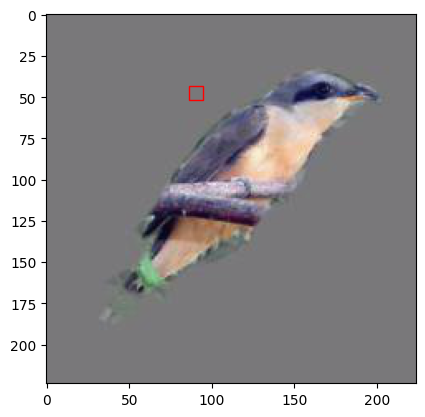

In [235]:
# %matplotlib notebook
%matplotlib inline

IMAGE_IDX_IN_CLASS = 0 # ALWAYS CONSIDERING THE FIRST IMAGE IN EACH CLASS

# # brown and white head
# LABEL = 8
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# # H_IDX, W_IDX = 10, 50 # stage 1
# H_IDX, W_IDX = 5, 18 # stage 2
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # background close to rear of head, initially tested with this
# LABEL = 8
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 4, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# background close to rear of head
LABEL = 8
I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
H_IDX, W_IDX = 5, 10
print('Label', LABEL)
print('Batch', I)
print('Within batch', BATCH_IDX)

# # background close to rear of head
# LABEL = 8
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 5, 10
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # duck face
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 4, 15
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # duck face,left=bottom grass region
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 24, 3
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # stick legs
# LABEL = 1
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 22, 11
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # black head
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 6, 20
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # black tail
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 12, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# # black tail, background bottom-left
# LABEL = 3
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 20, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

# black duck head
# LABEL = 4
# I, BATCH_IDX, IMAGE = class_images[LABEL][IMAGE_IDX_IN_CLASS]
# H_IDX, W_IDX = 2, 8
# print('Label', LABEL)
# print('Batch', I)
# print('Within batch', BATCH_IDX)

h_coor_min = H_IDX * (img_size / args.wshape)
h_coor_max = (H_IDX + 1) * (img_size / args.wshape)
w_coor_min = (W_IDX) * (img_size / args.wshape)
w_coor_max = (W_IDX + 1) * (img_size / args.wshape)

# h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(
#                 img_size, softmaxes_shape, patchsize, skip, H_IDX, W_IDX
#                 )

IMAGE = IMAGE.permute(1, 2, 0)  # Convert image to (H, W, C) format
min_val = IMAGE.min()
max_val = IMAGE.max()
IMAGE = (IMAGE - min_val) / (max_val - min_val)

# Plot bounding box with the selected color
plt.imshow(IMAGE)
plt.gca().add_patch(
    plt.Rectangle(
        (w_coor_min, h_coor_min),
        w_coor_max - w_coor_min,
        h_coor_max - h_coor_min,
        fill=False,
        edgecolor='red',
        linewidth=1
    )
)
plt.show()

# ref_vector = normalized_all_features[(I*BATCH_SIZE + BATCH_IDX)*(args.wshape ** 2) + H_IDX*args.wshape + W_IDX]

In [240]:
IMAGE.shape

torch.Size([224, 224, 3])

# Set choice of similarity metric

In [236]:
# USE_COSINE_SIMILARITY = False # True, False

# print('-*'*10, 'IMPORTANT', '-*'*10)
# if USE_COSINE_SIMILARITY:
#     print('-*'*10, 'Using COSINE SIMILARITY', '-*'*10)
# else:
#     print('-*'*10, 'Using INNER PRODUCT', '-*'*10)

# Heatmap - the region's similarity with other regions within the image

In [237]:
# with torch.no_grad():
#     _, _, image_under_consideration = class_images[LABEL][IMAGE_IDX_IN_CLASS]
#     model_input = image_under_consideration.unsqueeze(0).cuda()
#     features = net(model_input)
#     ref_vector_as_tensor = features[:, :, H_IDX, W_IDX].unsqueeze(-1).unsqueeze(-1).cuda()
#     similarity = functional_UnitConv2D(in_features=features, weight=ref_vector_as_tensor, bias=None)
#     overlayed_similarity = get_heatmap_uninterpolated(similarity.squeeze(0), IMAGE.squeeze(0).permute(2, 0, 1))
    
#     plt.imshow(overlayed_similarity)
#     plt.show()

In [241]:
def find_top_percentile_bbox(image, percentile=95):
    pdb.set_trace()
    threshold = np.percentile(image.flatten(), percentile)
    mask = image >= threshold
    coords = np.argwhere(mask)
    if coords.size == 0:
        return None, None, None, None
    h_min, w_min = coords.min(axis=0)
    h_max, w_max = coords.max(axis=0)
    h_min, h_max, w_min, w_max = map(int, [h_min, h_max, w_min, w_max])
    return h_min, h_max, w_min, w_max

def find_high_activation_crop(activation_map, percentile=95):
    threshold = np.percentile(activation_map, percentile)
    mask = np.ones(activation_map.shape)
    mask[activation_map < threshold] = 0
    lower_y, upper_y, lower_x, upper_x = 0, 0, 0, 0
    for i in range(mask.shape[0]):
        if np.amax(mask[i]) > 0.5:
            lower_y = i
            break
    for i in reversed(range(mask.shape[0])):
        if np.amax(mask[i]) > 0.5:
            upper_y = i
            break
    for j in range(mask.shape[1]):
        if np.amax(mask[:,j]) > 0.5:
            lower_x = j
            break
    for j in reversed(range(mask.shape[1])):
        if np.amax(mask[:,j]) > 0.5:
            upper_x = j
            break
    return lower_y, upper_y+1, lower_x, upper_x+1

/tmp/ipykernel_71681/2284369540.py:33: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  resample=Image.NEAREST ))


<IPython.core.display.Javascript object>


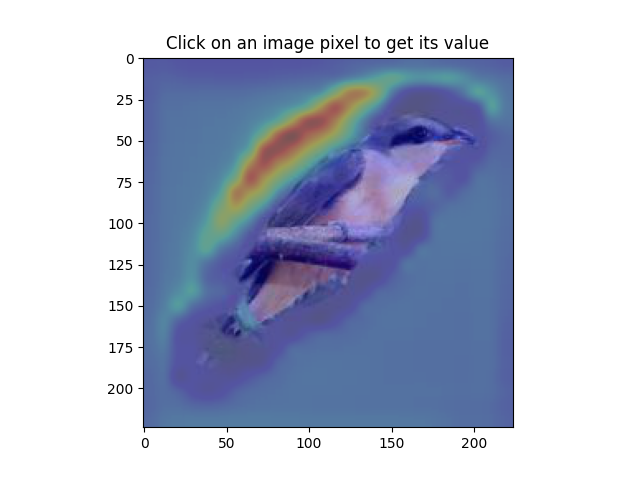

> /tmp/ipykernel_71681/1858926724.py(3)find_top_percentile_bbox()
      1 def find_top_percentile_bbox(image, percentile=95):
      2     pdb.set_trace()
----> 3     threshold = np.percentile(image.flatten(), percentile)
      4     mask = image >= threshold
      5     coords = np.argwhere(mask)

ipdb> image.shape
(224, 224)
ipdb> image.min()
-0.05664
ipdb> image.max()
1.0
ipdb> q


In [243]:
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline
%matplotlib notebook

with torch.no_grad():
    _, _, image_under_consideration = class_images[LABEL][IMAGE_IDX_IN_CLASS]
    model_input = image_under_consideration.unsqueeze(0).cuda()
    features = net(model_input)
    ref_vector_as_tensor = features[:, :, H_IDX, W_IDX].unsqueeze(-1).unsqueeze(-1).cuda()
    
    if USE_COSINE_SIMILARITY:
        similarity = functional_UnitConv2D(in_features=features, weight=ref_vector_as_tensor, bias=None)
    else:
        similarity = F.conv2d(features, ref_vector_as_tensor, None, stride=1, padding=0)
    
#     overlayed_similarity = get_heatmap_uninterpolated(similarity.squeeze(0), IMAGE.squeeze(0).permute(2, 0, 1))
    overlayed_similarity = get_heatmap(similarity.squeeze(0), IMAGE.squeeze(0).permute(2, 0, 1))
    upscaled_similarity = get_upscaled_activation_uninterpolated(similarity.squeeze(0), image_size=(224, 224))


# Display the random image
fig, ax = plt.subplots()
ax.imshow(overlayed_similarity)#, cmap='gray', vmin=0, vmax=1)  # Assuming grayscale image
ax.set_title('Click on an image pixel to get its value')

# Create a function to display text when hovering over a pixel
def motion_event(event):
    if event.inaxes is ax:
        x, y = int(event.xdata), int(event.ydata)
        pixel_value = upscaled_similarity[y, x]
        ax.set_title(f'Pixel value at ({x}, {y}): {pixel_value:.4f}', fontsize=12)

# Create a function to clear the text when not hovering over a pixel
def leave_event(event):
    ax.set_title('')
    plt.draw()

fig.canvas.mpl_connect('motion_notify_event', motion_event)
fig.canvas.mpl_connect('axes_leave_event', leave_event)

h_min, h_max, w_min, w_max = find_top_percentile_bbox(upscaled_similarity, percentile=95)

print(h_min, h_max, w_min, w_max)

plt.gca().add_patch(
    plt.Rectangle(
        (w_min, h_min),
        w_max - w_min,
        h_max - h_min,
        fill=False,
        edgecolor='blue',
        linewidth=1
    )
)


plt.gca().add_patch(
    plt.Rectangle(
        (w_coor_min, h_coor_min),
        w_coor_max - w_coor_min,
        h_coor_max - h_coor_min,
        fill=False,
        edgecolor='red',
        linewidth=1
    )
)

plt.show()


In [182]:
from pipnet.train import flatten_tensor

img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

BATCH_SIZE = projectloader.batch_size
all_features = torch.empty(0, softmaxes_shape[1]).to(device)
for _i, (xs, ys) in img_iter:
    xs, ys = xs.to(device), ys.to(device)
    
#     # This filter is to check only among the same species, remove this if you wanna consider all species
#     if not ys.item() == LABEL:
#         continue
        
    with torch.no_grad():
        features = net(xs)
        flattened_features = flatten_tensor(features)
        all_features = torch.cat((all_features, flattened_features))

if USE_COSINE_SIMILARITY:
    normalized_all_features = F.normalize(all_features, p=2, dim=1)
else:
    normalized_all_features  = all_features

In [356]:
print(normalized_all_features.shape)

torch.Size([365040, 768])


In [357]:
import time
start_ = time.time()

top_k = 30 # keep it a multiple of 5

normalized_all_features = normalized_all_features.cpu().numpy()

ref_vector = normalized_all_features[(I*BATCH_SIZE + BATCH_IDX)*(args.wshape ** 2) + H_IDX*args.wshape + W_IDX]

inner_products = np.dot(normalized_all_features, ref_vector)
sorted_indices = np.argsort(inner_products)[::-1]

top_k_indices = sorted_indices[:top_k]
top_k_vectors = normalized_all_features[top_k_indices]
top_k_inner_products = inner_products[top_k_indices]

print(time.time() - start_)

0.2409682273864746


In [358]:
print('IMPORTANT - this should be TRUE, this is to verify the accuracy of choosing the ref_vector')
# print(F.normalize(ref_vector_as_tensor.cpu(), p=2, dim=1).squeeze().numpy() == ref_vector)
print((F.normalize(ref_vector_as_tensor.cpu(), p=2, dim=(1, 2, 3)).squeeze().numpy() == ref_vector).all())

IMPORTANT - this should be TRUE, this is to verify the accuracy of choosing the ref_vector
False


In [359]:
# x = F.normalize(ref_vector_as_tensor.cpu(), p=2, dim=(1, 2, 3)).squeeze(-1).squeeze(-1)#.numpy()
# print(x.shape)
# print("sum elements: ", torch.sum(torch.pow(x,2), dim=1).shape, torch.sum(torch.pow(x,2), dim=1))

In [360]:
# maps (i, batch_idx) to (h_idx, w_idx)
nearest_patches_indices = defaultdict(list)

for feature_idx, inner_product in zip(top_k_indices, top_k_inner_products):
    _i = int((feature_idx / (args.wshape ** 2)) / BATCH_SIZE)
    
    _batch_idx = int((feature_idx / (args.wshape ** 2)) % BATCH_SIZE)
    _h_idx = int((feature_idx % (args.wshape ** 2)) / args.wshape)
    _w_idx = int((feature_idx % (args.wshape ** 2)) % args.wshape)
    
    nearest_patches_indices[(_i, _batch_idx)].append((_h_idx, _w_idx, inner_product))
    
    print((_i, _batch_idx, _h_idx, _w_idx, inner_product))

(90, 0, 12, 8, 1.0000001)
(90, 0, 12, 7, 0.973453)
(90, 0, 12, 9, 0.94664186)
(90, 0, 12, 6, 0.9240408)
(90, 0, 12, 5, 0.8736398)
(292, 0, 11, 6, 0.86922234)
(292, 0, 11, 7, 0.86200136)
(259, 0, 14, 6, 0.85966414)
(111, 0, 16, 7, 0.85515183)
(214, 0, 10, 19, 0.85463345)
(214, 0, 10, 18, 0.8509613)
(292, 0, 11, 5, 0.84170765)
(291, 0, 9, 10, 0.83788526)
(106, 0, 13, 16, 0.8365619)
(106, 0, 12, 15, 0.8365607)
(259, 0, 14, 5, 0.83594394)
(118, 0, 13, 7, 0.83593655)
(278, 0, 12, 15, 0.8353688)
(149, 0, 7, 7, 0.83517176)
(291, 0, 9, 9, 0.8337816)
(278, 0, 12, 16, 0.83180565)
(118, 0, 13, 6, 0.8305748)
(149, 0, 7, 8, 0.8304701)
(90, 0, 12, 4, 0.8216434)
(90, 0, 13, 7, 0.8199128)
(292, 0, 11, 8, 0.8196949)
(111, 0, 16, 6, 0.81854093)
(292, 0, 10, 6, 0.814647)
(214, 0, 10, 20, 0.8145719)
(106, 0, 12, 16, 0.81288606)


In [361]:
img_iter = tqdm(enumerate(projectloader),
                    total=len(projectloader),
                    mininterval=50.,
                    desc='Collecting topk',
                    ncols=0)

img_list = []
bbox_list = []
for _i, (xs, ys) in img_iter:
    xs, ys = xs.to(device), ys.to(device)
    images, class_labels = xs, ys
    
#     # This filter is to check only among the same species, remove this if you wanna consider all species
#     if not ys.item() == LABEL:
#         continue
        
    for _batch_idx in range(len(class_labels)):
        label = class_labels[_batch_idx].item()
        image = images[_batch_idx]
                
        if (_i, _batch_idx) in nearest_patches_indices:
            image = image.permute(1, 2, 0)  # Convert image to (H, W, C) format
            min_val = image.min()
            max_val = image.max()
            image = (image - min_val) / (max_val - min_val)
            img_list.append(image.cpu().numpy())
            
            bboxes = []
            for _h_idx, _w_idx, inner_product in nearest_patches_indices[(_i, _batch_idx)]:
                h_coor_min, h_coor_max, w_coor_min, w_coor_max = get_img_coordinates(
                    img_size, softmaxes_shape, patchsize, skip, _h_idx, _w_idx
                    )
                bboxes.append((h_coor_min, h_coor_max, w_coor_min, w_coor_max, inner_product))
            bbox_list.append(bboxes)
            
            
print(len(img_list), len(img_list) == len(bbox_list))

10 True


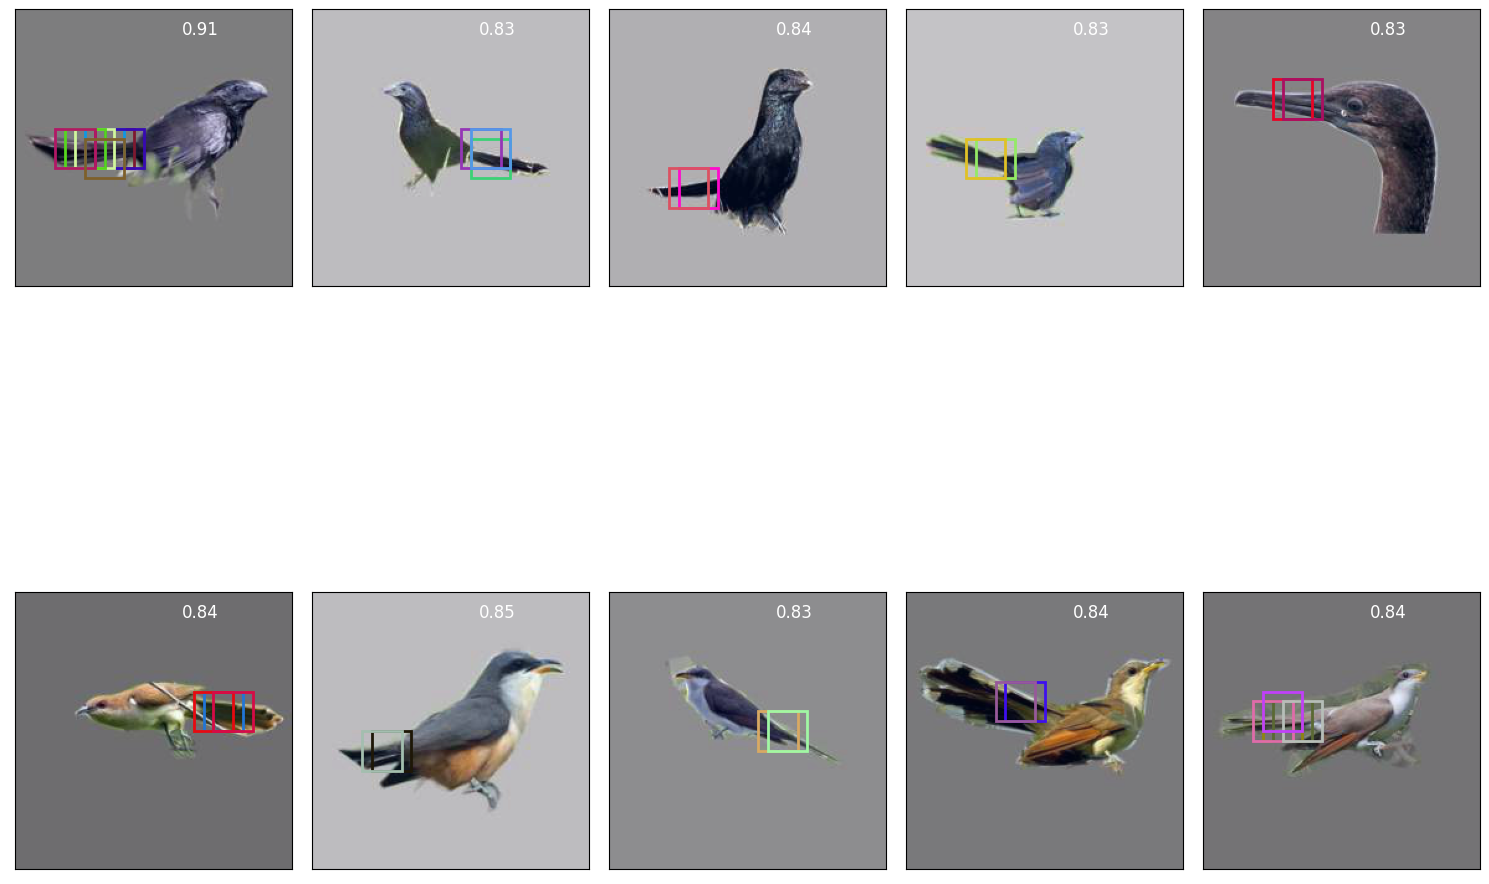

In [362]:
num_images = len(img_list)
num_rows = num_images // 5
if (num_images % 5) != 0:
    num_rows += 1
if num_images < 5:
    num_cols = num_images
else:
    num_cols = 5

# Create a figure and axis for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, (image, bboxes) in enumerate(zip(img_list, bbox_list)):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    if num_images == 1:
        ax = axes
    elif num_rows > 1:
        ax = axes[row_idx, col_idx]
    else:
        ax = axes[col_idx]

    # Display the image
    ax.imshow(image)
    
    # Plot bounding boxes on the image
    for bbox in bboxes:
        h_coor_min, h_coor_max, w_coor_min, w_coor_max, inner_product = bbox
        rect = plt.Rectangle(
            (w_coor_min, h_coor_min),
            w_coor_max - w_coor_min,
            h_coor_max - h_coor_min,
            fill=False,
            edgecolor=(random.random(), random.random(), random.random()),  # Random color
            linewidth=2
        )
        ax.add_patch(rect)
    
    top_right_description = str(round(np.mean([ip for *_, ip in bboxes]), 2))
    height, width, _ = image.shape
    x_pos = width - 60  # Adjust the value to fit the text inside the image bounds
    y_pos = 20          # Adjust the value according to the desired height
    # Add text on the top-right corner
    ax.text(x_pos, y_pos, top_right_description, fontsize=12, color='white', horizontalalignment='right')


    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of images with bounding boxes
plt.show()